<a href="https://colab.research.google.com/github/parthgiri01/WEEK-4-TEST/blob/main/24172815_ML%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New section

Generated synthetic dataset:
   Flow Duration  Fwd Packet Length Max  Bwd IAT Total Protocol  is_malicious
0      18.789552             694.280981     783.079882      TCP             0
1      47.540644            1062.186493     483.373005      UDP             0
2      36.626498             887.587732     531.138093      UDP             0
3      29.973058             458.593288     242.814856      UDP             0
4       7.885330            1236.134027     894.737533      UDP             0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Flow Duration          50000 non-null  float64
 1   Fwd Packet Length Max  47571 non-null  float64
 2   Bwd IAT Total          47548 non-null  float64
 3   Protocol               50000 non-null  object 
 4   is_malicious           50000 non-null  int64  
dtypes: float64(

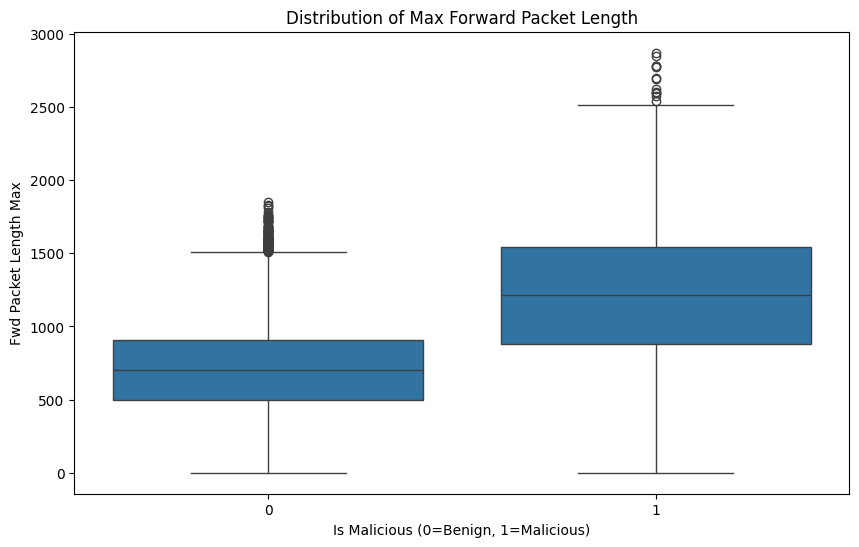

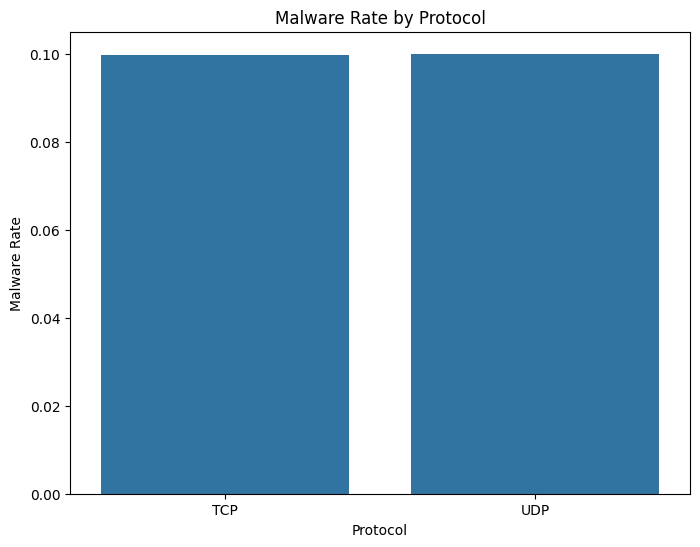


--- Data Pre-processing ---
Initial null values:
 Flow Duration               0
Fwd Packet Length Max    2429
Bwd IAT Total            2452
Protocol                    0
is_malicious                0
dtype: int64
Null values after imputation:
 Flow Duration            0
Fwd Packet Length Max    0
Bwd IAT Total            0
Protocol                 0
is_malicious             0
dtype: int64
Initial class distribution:
 is_malicious
0    45000
1     5000
Name: count, dtype: int64
Class distribution after SMOTE-ENN:
 is_malicious
1    40265
0    37513
Name: count, dtype: int64

--- Model Training & Evaluation ---
Training Random Forest...

Random Forest Results:
Confusion Matrix:
 [[10963   284]
 [  780 11307]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     11247
           1       0.98      0.94      0.96     12087

    accuracy                           0.95     23334
   macro avg       0.95      0.96      0

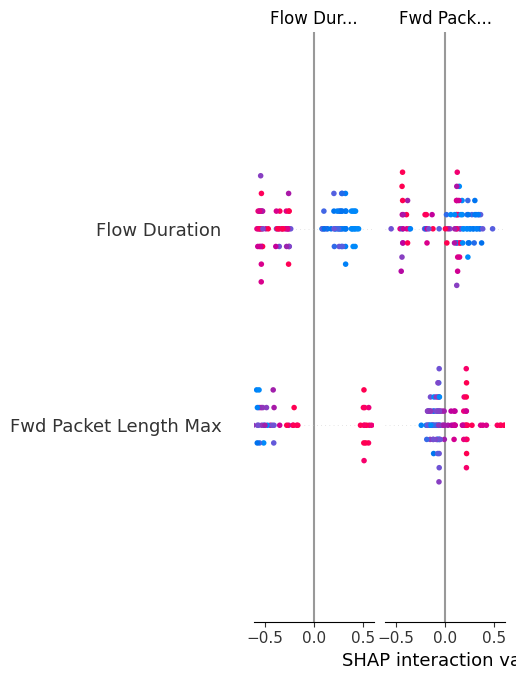

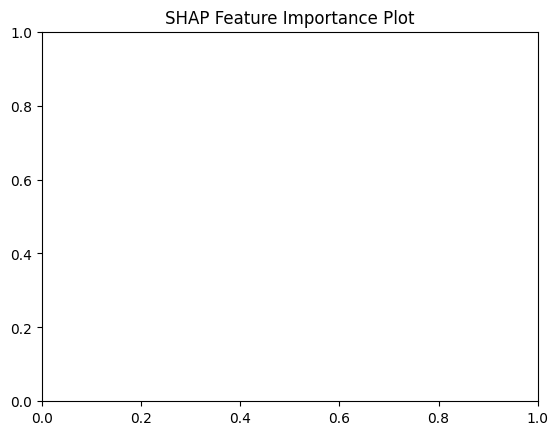

In [3]:
# --- 0. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.combine import SMOTEENN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Input
import warnings

# Suppress specific FutureWarnings from NumPy used by SHAP
warnings.filterwarnings("ignore", message="The NumPy global RNG was seeded by calling `np.random.seed`")

# Optional: SHAP for explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

# --- 1. Data Generation (Synthetic Dataset) ---
def generate_synthetic_data(num_samples=50000):
    np.random.seed(42)
    features = {
        'Flow Duration': np.random.uniform(0.1, 50, num_samples),
        'Fwd Packet Length Max': np.random.normal(loc=700, scale=300, size=num_samples).clip(0),
        'Bwd IAT Total': np.random.uniform(0, 1000, num_samples),
        'Protocol': np.random.choice(['TCP', 'UDP'], size=num_samples),
        'is_malicious': np.zeros(num_samples, dtype=int)
    }
    df = pd.DataFrame(features)

    # Introduce malicious traffic (10%) with distinct characteristics
    num_malicious = int(num_samples * 0.10)
    malicious_indices = np.random.choice(df.index, num_malicious, replace=False)

    df.loc[malicious_indices, 'is_malicious'] = 1
    df.loc[malicious_indices, 'Fwd Packet Length Max'] = np.random.normal(loc=1200, scale=500, size=num_malicious).clip(0)
    df.loc[malicious_indices, 'Flow Duration'] = np.random.uniform(10, 150, size=num_malicious)

    # Introduce some missing values
    df.loc[np.random.choice(df.index, int(num_samples * 0.05)), 'Bwd IAT Total'] = np.nan
    df.loc[np.random.choice(df.index, int(num_samples * 0.05)), 'Fwd Packet Length Max'] = np.nan

    return df

df = generate_synthetic_data()
print("Generated synthetic dataset:")
print(df.head())
print("\nDataset Info:")
print(df.info())

# --- 2. Exploratory Data Analysis (EDA) ---
print("\n--- Exploratory Data Analysis ---")

# Boxplot: Fwd Packet Length Max by class
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_malicious', y='Fwd Packet Length Max', data=df)
plt.title('Distribution of Max Forward Packet Length')
plt.xlabel('Is Malicious (0=Benign, 1=Malicious)')
plt.ylabel('Fwd Packet Length Max')
plt.show()

# Malware rate by protocol
protocol_malware_rate = df.groupby('Protocol')['is_malicious'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='Protocol', y='is_malicious', data=protocol_malware_rate)
plt.title('Malware Rate by Protocol')
plt.xlabel('Protocol')
plt.ylabel('Malware Rate')
plt.show()

# --- 3. Data Pre-processing ---
print("\n--- Data Pre-processing ---")
print("Initial null values:\n", df.isnull().sum())

# Impute missing values without inplace warnings
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Null values after imputation:\n", df.isnull().sum())

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['Protocol'], drop_first=True)

# Features and target
X = df.drop('is_malicious', axis=1)
y = df['is_malicious']

# Handle class imbalance with SMOTE-ENN
print("Initial class distribution:\n", y.value_counts())
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
print("Class distribution after SMOTE-ENN:\n", y_resampled.value_counts())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 4. Model Training & Evaluation ---
print("\n--- Model Training & Evaluation ---")

## a) Random Forest
print("Training Random Forest...")
# Reduce the training data size for Random Forest
X_train_rf_subset, _, y_train_rf_subset, _ = train_test_split(
    X_train, y_train, test_size=0.95, random_state=42, stratify=y_train
)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf_subset, y_train_rf_subset)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

## b) SVM on a small subset (for speed)
print("Training SVM (subset)...")
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, test_size=0.95, random_state=42, stratify=y_train
)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_small, y_train_small)
y_pred_svm = svm_model.predict(X_test)
print("\nSVM Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

## c) LSTM on a small subset
print("Training LSTM...")
X_train_lstm_subset, _, y_train_lstm_subset, _ = train_test_split(
    X_train, y_train, test_size=0.95, random_state=42, stratify=y_train
)
X_train_lstm = np.reshape(X_train_lstm_subset, (X_train_lstm_subset.shape[0], 1, X_train_lstm_subset.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_lstm_subset, epochs=2, batch_size=64, validation_split=0.1, verbose=1)

y_pred_prob_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype("int32")
print("\nLSTM Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lstm))
print("Classification Report:\n", classification_report(y_test, y_pred_lstm))

# --- 5. Explainability with SHAP (optional) ---
if SHAP_AVAILABLE:
    print("\n--- Generating SHAP values for Random Forest ---")
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test[:100])
    shap.summary_plot(shap_values, X_test[:100], feature_names=X.columns)
    plt.title("SHAP Feature Importance Plot")
    plt.show()
else:
    print("\nSHAP library not found. Install with 'pip install shap' to enable explainability.")